# The Limits of Machine Learning

## Copyright notice

This version (c) 2018 Fabian Offert, [MIT License](LICENSE).

## Background

One core problem of contemporary machine learning techniques, as pointed out by [Marcus 2017], [Lake et. al. 2017], and many others, is a lack of symbolic reasoning skills in purely statistically trained ("deep learning" type) models like convolutional neural networks. While [Lake et. al. 2017] propose many possible technological fixes for this problem (for instance, the integration of a game-engine style physics model into a network), we could ask with [Agre 1995] if these fixes do not simply defer an inherently philosophical problem: the problem that, despite neural networks being general function approximators, intelligent generalization can not be modeled with general function approximation. As [Marcus 2017] writes: 

> The real problem lies in misunderstanding what deep learning is, and is not, good for. The technique excels at solving closed-end classification problems, in which a wide range of potential signals must be mapped onto a limited number of categories, given that there is enough data available and the test set closely resembles the training set. [...] [S]ome problems cannot, given real- world limitations, be thought of as classification problems at all. Open-ended natural language understanding, for example, should not be thought of as a classifier mapping between a large finite set of sentences and large, finite set of sentences, but rather a mapping between a potentially infinite range of input sentences and an equally vast array of meanings, many never previously encountered. In a problem like that, deep learning becomes a square peg slammed into a round hole, a crude approximation when there must be a solution elsewhere.

In other words, "true" generalization would be closer to Cartesian compositionality then to a very large mapping betwen domains. As an illustration of his argument, [Marcus 2017] proposes a toy example: generalizing from even to odd numbers:

> Distilling the broad-ranging problems of language down to a simple example that I believe still has resonance now, I ran a series of experiments in which I trained three-layer perceptrons (fully connected in today’s technical parlance, with no convolution) on the identity function, $f(x) = x$, e.g, $f(12)=12$.

The technical setup for the experiment is simple:

> 1997-vintage networks were, to be sure, simpler than current models — they used no more than three layers (inputs nodes connected to hidden nodes connected to outputs node), and lacked Lecun’s powerful convolution technique. But they were driven by backpropagation just as today’s systems are, and just as beholden to their training data.

The results are straightforward:

> Every time I ran the experiment, using a wide variety of parameters, the results were the same: the network would (unless it got stuck in local minimum) correctly apply the identity function to the even numbers that it had seen before (say 2, 4, 8 and 12), and to some other even numbers (say 6 and 14) but fail on all the odds numbers, yielding, for example f(15) = 14. [...] Odd numbers were outside the training space, and the networks could not generalize identity outside that space. Adding more hidden units didn’t help, and nor did adding more hidden layers. Simple multilayer perceptrons simply couldn’t generalize outside their training space [...].

In the following, we will reproduce the experiment described in [Marcus:2017]. The intention behind this is not so much the validation of their results but an excercise in critical technical practice ([Agre 1997]), in translating between philosophical and technical contexts. Additionally, given the availability of tools compared to 1997, we can implement some simple variations of the proposed experiment and potentially show that the results still hold. 

## Imports

To be able to use mechanisms like differentiation and backpropagation we need a high-level library that abstracts these mathematical details away from us. We are using Keras, the de-facto standard for high-level prototyping for machine learning. Keras is a front-end to the Tensorflow framework, which is one of the most widely used machine learning frameworks. Because we are operating in high-dimensional vector space, we are also using Numpy, the Python library for scientific computing. Finally, we are importing three helper functions, to split our data into train and test sets, and to plot our activation functions.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Settings

These constants are the hyperparameters for our neural network. Exactly as proposed by [Marcus 2017], we are implementing the identity function $f(x) = x$ for binary integers. Our parameters are:

- Our integers have `BITS` bits, so our network should learn to apply the identify function for $\frac{2^{\text{BITS}}}{2}$ possible *even* integers.
- After training we will test our network on `VAL` validation samples that are kept back.
- Our hidden layers consist of `HIDDEN` units each.
- We use `LAYERS` layers total.
- We train the network for `EPOCHS` "epochs". One epoch is a complete "run" of all available training samples, i.e. a single forward and backward pass with all available samples.
- We pass the samples to the network in batches of `BATCHES` each, this saves memory.
- We do integrate some dropout layers to prevent overfitting (particularly important in this case).
- Finally we "mix in" `MIX` odd numbers into our even numbers to find the threshold that enables the network to generalize for even and odd numbers.

In [2]:
BITS = 16
VAL = 25
HIDDEN = 128
LAYERS = 3
EPOCHS = 2000
BATCHES = 128
DROPOUT = False
MIX = 50

print(2**16)

65536


## Function to approximate

We define the most simple function possible, the identity function $f(x) = x$. To allow some additional experiments, we also define the bitwise-not function, $f(x)=\sim{x}$. Note that the numpy implementation of bitwise not returns an array of truth values. To convert this into an array of 0s and 1s, we simply multiply it by 1.

In [3]:
def f(x):
    
    # Identity
    return x
    
    # Bitwise not
    # return  np.logical_not(x) * 1

## Creating the training data

Our training data is simple: a set of binary values, encoded as `BITS` dimensional vectors (e.g. `[0, 0, 1, 1, 1]`), provides both the input and desired output of our network. To produce this set, we create two two-dimensional arrays (`x_even` and `x_odd`) that will hold the even and odd numbers, respectively. We then fill the arrays from the bottom up, by iterating over the range of all $2^{\text{BITS}}$ possible numbers with a step width of 2. In each step, we write the current number to the array that holds the even numbers, and the current number minus one to the array that holds the odd numbers. We randomly shuffle both arrays, and reserve a part for testing, and another (smaller) part for validation. Finally, we apply the function defined above to a copy of the array of even numbers, and use this as the target.

In [4]:
MAX = 2**BITS # BITS bits = 2^BITS values

# Make space for all even BITS-bit numbers and all odd BITS-bit numbers
x_even = np.zeros((int(MAX/2), BITS), dtype=int)
x_odd = np.zeros((int(MAX/2), BITS), dtype=int)

# Fill from the bottom, converting to binary on the fly
for i in range(0, MAX, 2):
    x_even[int(i/2),:] = np.array(list(np.binary_repr(i, BITS)))
    x_odd[int(i/2),:] = np.array(list(np.binary_repr(i+1, BITS)))

# Randomly shuffle everything    
np.random.shuffle(x_even)
np.random.shuffle(x_odd)

x_val_even = x_even[-VAL:,:] # Save last VAL random even numbers for prediction 
x_even = x_even[:-VAL,:] # (use the rest for training and testing)
x_val_odd = x_odd[-VAL:,:] # Save last VAL random odd numbers for prediction (throw the rest away)

x_even[:MIX,:] = x_odd[:MIX,:]
# Randomly shuffle again   
np.random.shuffle(x_even)

# Apply function we would like to model
y = f(x_even)

# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train, x_test, y_train, y_test = train_test_split(x_even, y, test_size=0.1, random_state=42)

print(str(BITS) + ' bit numbers = ' + str(MAX) + ' possible values.')
print("Train set: " + str(len(x_train)) + ' even binary vectors (' + str(MIX) + ' odd mixed into total set).')
print("Test set: " + str(len(x_test)) + ' even binary vectors (' + str(MIX) + ' odd mixed into total set).')
print("Validation set: " + str(len(x_val_even)) + ' even binary vectors and ' + str(len(x_val_odd)) + ' odd binary vectors.')

16 bit numbers = 65536 possible values.
Train set: 29468 even binary vectors (50 odd mixed into total set).
Test set: 3275 even binary vectors (50 odd mixed into total set).
Validation set: 25 even binary vectors and 25 odd binary vectors.


## Building the model

Keras conveniently provides us with abstractions for many of the most commonly used building blocks of neural networks. For this experiment, we are using six different components: fully connected layers, ReLu activation, sigmoid activation, a binary cross-entropy loss function, and backpropagation by means of stochastic gradient descent.

### Fully connected layer

This is the standard, multilayer perceptron layer, where every unit of a layer is connected to every unit of the layer before and after. 

### ReLu activation function

[Rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) are the most popular neural network units at the time of writing. Despite their "linear look", the [activation function](https://en.wikipedia.org/wiki/Activation_function) used: 

$$f(x)=\max(0,x)$$

is actually nonlinear ([piecewise-linear](https://en.wikipedia.org/wiki/Piecewise_linear_function), to be precise) *and* differentiable. Why nonlinear? Well, a linear function has to satisfy the condition 

$$\forall_{x,y}: f(x) + f(y) = f(x+y)$$

For ReLu, 

$$f(-1) = -1$$
$$f(1) = 1$$
$$f(0) = 0$$ 

Its derivative is then simply 

$$f'(x)={\begin{cases}0&{\text{for }}x<0\\1&{\text{for }}x\geq 0\end{cases}}$$

Interestingly, the "almost-linearity" of ReLus does not impede their universality in approximating functions (see [these examples](https://www.quora.com/Is-a-single-layered-ReLu-network-still-a-universal-approximator/answer/Conner-Davis-2)).

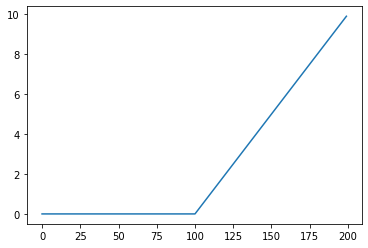

In [5]:
plt.plot([max(0, x) for x in np.arange(-10.0,10.0,0.1)])
plt.show()

### Sigmoid activation function

The [sigmoid function](https://en.wikipedia.org/wiki/Logistic_function), also called logistic function, looks roughly like the simple step function but has non-zero gradients everywhere, which makes it fully differentiable. It is defined as

$$f(x)={\frac {1}{1+e^{-x}}}$$

with the derivative

$$f'(x)=f(x)(1-f(x))$$

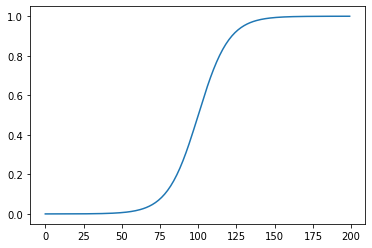

In [6]:
plt.plot([sigmoid(x) for x in np.arange(-10.0,10.0,0.1)])
plt.show()

### Binary cross-entopy loss function

Because our input and output are binary numbers, we are dealing with a [multi-label classification]( https://en.wikipedia.org/wiki/Multi-label_classification) problem. The loss function best suited to address this scenario is binary [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy). In mathematical terms, minimizing this function equals minimizing the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), here the divergence of the probability distribution inherent in the training set and the probability distribution created by the model.

### Backpropagation via stochastic gradient descent

First, a quick derivative reminder:

$$\frac{df}{dx} = \lim_{x \to +\infty} \frac{f(x+h)-f(x)}{h}$$

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is based on the observation that if the multi-variable function $f(x)$ is defined and differentiable in a neighborhood of a point $a$, then $f(x)$ decreases fastest if one goes from $a$ in the direction of the negative gradient of $f$ at $a$, $f(a) -\nabla f(a)$. The algorithm for a system with the loss function $Loss$ would then be

$$w_n \leftarrow w_n - \underbrace{\eta}_\text{step size} \nabla_{w_{n}} Loss(w_n)$$

for every training sample, where $\nabla_{w_{n}}$ ([Del](https://en.wikipedia.org/wiki/Del)) denotes the partial derivative w. r. t. the weight $w_n$, which can usually be derived by means of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$(f\circ g)'=(f'\circ g)\cdot g'$$

[Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) adds an additional element to the process to increase throughput: batch size. Instead of supplying one training sample per iteration (where iteration defines one forward and backward pass), multiple (random) samples are concatenated and the network is trained on these concatenated "mini-batches". Essentially, we are trading dimensionality for speed which is intuitively a good choice if we use GPUs for training.

Example: $f(x)=x^4−3x^3+2$, with derivative $f'(x)=4x3−9x^2$

In [7]:
# From calculation, it is expected that the local minimum occurs at x=9/4

x = 6 # The algorithm starts at x=6
eta = 0.01 # Step size multiplier
precision = 0.00001
previous_step_size = 1/precision # Some large value

df = lambda x: 4 * x**3 - 9 * x**2

while previous_step_size > precision:
    prev_x = x
    x += -eta * df(prev_x)
    previous_step_size = abs(x - prev_x)

print("The local minimum occurs at " + str(x))

The local minimum occurs at 2.2499646074278457


In [8]:
model = Sequential()
# Dense(HIDDEN) is a fully-connected layer with HIDDEN hidden units.
# In the first layer, you must specify the expected input data shape, here BITS-dimensional vectors.
model.add(layers.Dense(HIDDEN, activation='relu', input_dim=BITS))
for _ in range(LAYERS-1):
    model.add(layers.Dense(HIDDEN, activation='relu'))
    if (DROPOUT): model.add(layers.Dropout(0.5))
# Sigmoid activation for multilabel classification
# https://github.com/keras-team/keras/issues/741
# https://en.wikipedia.org/wiki/Multi-label_classification
model.add(layers.Dense(BITS, activation='sigmoid'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Binary crossentropy for multilabel classification
# https://github.com/keras-team/keras/issues/741
# https://en.wikipedia.org/wiki/Multi-label_classification
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
Total params: 37,264
Trainable params: 37,264
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [9]:
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCHES)
score = model.evaluate(x_test, y_test, batch_size=128)




Epoch 1/2000





29468/29468 [==============================] - 2s 74us/step - loss: 0.6392 - acc: 0.6710
Epoch 2/2000
29468/29468 [==============================] - 1s 46us/step - loss: 0.4929 - acc: 0.8866
Epoch 3/2000
29468/29468 [==============================] - 1s 40us/step - loss: 0.2768 - acc: 0.9615
Epoch 4/2000
29468/29468 [==============================] - 1s 35us/step - loss: 0.1132 - acc: 0.9959
Epoch 5/2000
29468/29468 [==============================] - 1s 41us/step - loss: 0.0465 - acc: 0.9998
Epoch 6/2000
29468/29468 [==============================] - 1s 33us/step - loss: 0.0247 - acc: 0.9999
Epoch 7/2000
29468/29468 [==============================] - 1s 30us/step - loss: 0.0161 - acc: 0.9999
Epoch 8/2000
29468/29468 [==============================] - 1s 27us/step - loss: 0.0118 - acc: 0.9999
Epoch 9/2000
29468/29468 [==============================] - 1s 24us/step - loss: 0.0092 - acc: 0.9999
Epoch 10/2000
29468/29468 [==============================] - 1s 23us/step 

29468/29468 [==============================] - 2s 58us/step - loss: 9.4524e-04 - acc: 0.9999
Epoch 65/2000
29468/29468 [==============================] - 2s 59us/step - loss: 9.3812e-04 - acc: 0.9999
Epoch 66/2000
29468/29468 [==============================] - 2s 62us/step - loss: 9.2747e-04 - acc: 0.9999
Epoch 67/2000
29468/29468 [==============================] - 2s 60us/step - loss: 9.1607e-04 - acc: 0.9999
Epoch 68/2000
29468/29468 [==============================] - 2s 61us/step - loss: 9.1235e-04 - acc: 0.9999
Epoch 69/2000
29468/29468 [==============================] - 2s 62us/step - loss: 8.9662e-04 - acc: 0.9999
Epoch 70/2000
29468/29468 [==============================] - 2s 60us/step - loss: 8.9409e-04 - acc: 0.9999
Epoch 71/2000
29468/29468 [==============================] - 2s 57us/step - loss: 8.8289e-04 - acc: 0.9999
Epoch 72/2000
29468/29468 [==============================] - 2s 64us/step - loss: 8.7653e-04 - acc: 0.9999
Epoch 73/2000
29468/29468 [========================

29468/29468 [==============================] - 1s 40us/step - loss: 4.4974e-04 - acc: 0.9999
Epoch 141/2000
29468/29468 [==============================] - 1s 39us/step - loss: 4.4597e-04 - acc: 0.9999
Epoch 142/2000
29468/29468 [==============================] - 1s 40us/step - loss: 4.3559e-04 - acc: 0.9999: 0s - loss: 3.6
Epoch 143/2000
29468/29468 [==============================] - 1s 43us/step - loss: 4.2707e-04 - acc: 0.9999
Epoch 144/2000
29468/29468 [==============================] - 1s 39us/step - loss: 4.2777e-04 - acc: 0.9999
Epoch 145/2000
29468/29468 [==============================] - 1s 41us/step - loss: 4.1538e-04 - acc: 0.9999
Epoch 146/2000
29468/29468 [==============================] - 1s 41us/step - loss: 4.1045e-04 - acc: 0.9999
Epoch 147/2000
29468/29468 [==============================] - 1s 39us/step - loss: 4.0018e-04 - acc: 0.9999
Epoch 148/2000
29468/29468 [==============================] - 1s 41us/step - loss: 3.9633e-04 - acc: 0.9999
Epoch 149/2000
29468/29468 

29468/29468 [==============================] - 1s 41us/step - loss: 1.0981e-04 - acc: 1.0000
Epoch 216/2000
29468/29468 [==============================] - 1s 39us/step - loss: 1.0825e-04 - acc: 1.0000
Epoch 217/2000
29468/29468 [==============================] - 1s 40us/step - loss: 1.0703e-04 - acc: 1.0000
Epoch 218/2000
29468/29468 [==============================] - 1s 41us/step - loss: 1.0587e-04 - acc: 1.0000
Epoch 219/2000
29468/29468 [==============================] - 1s 40us/step - loss: 1.0395e-04 - acc: 1.0000
Epoch 220/2000
29468/29468 [==============================] - 1s 39us/step - loss: 1.0281e-04 - acc: 1.0000
Epoch 221/2000
29468/29468 [==============================] - 1s 39us/step - loss: 1.0173e-04 - acc: 1.0000
Epoch 222/2000
29468/29468 [==============================] - 1s 42us/step - loss: 1.0053e-04 - acc: 1.0000
Epoch 223/2000
29468/29468 [==============================] - 1s 41us/step - loss: 9.9287e-05 - acc: 1.0000
Epoch 224/2000
29468/29468 [===============

Epoch 291/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6622e-05 - acc: 1.0000
Epoch 292/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6299e-05 - acc: 1.0000
Epoch 293/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.5955e-05 - acc: 1.0000
Epoch 294/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.5648e-05 - acc: 1.0000
Epoch 295/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.5266e-05 - acc: 1.0000
Epoch 296/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4958e-05 - acc: 1.0000
Epoch 297/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4603e-05 - acc: 1.0000
Epoch 298/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4363e-05 - acc: 1.0000
Epoch 299/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.3989e-05 - acc: 1.0000
Epoch 300/2000
29468/29468 [

29468/29468 [==============================] - 1s 18us/step - loss: 3.8988e-05 - acc: 1.0000
Epoch 367/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.8843e-05 - acc: 1.0000
Epoch 368/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.8691e-05 - acc: 1.0000
Epoch 369/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.8523e-05 - acc: 1.0000
Epoch 370/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.8359e-05 - acc: 1.0000
Epoch 371/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.8216e-05 - acc: 1.0000
Epoch 372/2000
29468/29468 [==============================] - 1s 19us/step - loss: 3.8069e-05 - acc: 1.0000
Epoch 373/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.7916e-05 - acc: 1.0000
Epoch 374/2000
29468/29468 [==============================] - 1s 18us/step - loss: 3.7754e-05 - acc: 1.0000
Epoch 375/2000
29468/29468 [===============

Epoch 442/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9723e-05 - acc: 1.0000
Epoch 443/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9632e-05 - acc: 1.0000
Epoch 444/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9547e-05 - acc: 1.0000
Epoch 445/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9448e-05 - acc: 1.0000
Epoch 446/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9368e-05 - acc: 1.0000
Epoch 447/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9270e-05 - acc: 1.0000
Epoch 448/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9187e-05 - acc: 1.0000
Epoch 449/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9104e-05 - acc: 1.0000
Epoch 450/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.9003e-05 - acc: 1.0000
Epoch 451/2000
29468/29468 [

29468/29468 [==============================] - 1s 18us/step - loss: 2.4086e-05 - acc: 1.0000
Epoch 518/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.4025e-05 - acc: 1.0000
Epoch 519/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3964e-05 - acc: 1.0000
Epoch 520/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3904e-05 - acc: 1.0000
Epoch 521/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3846e-05 - acc: 1.0000
Epoch 522/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3781e-05 - acc: 1.0000
Epoch 523/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3734e-05 - acc: 1.0000
Epoch 524/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3663e-05 - acc: 1.0000
Epoch 525/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.3606e-05 - acc: 1.0000
Epoch 526/2000
29468/29468 [===============

Epoch 593/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.0215e-05 - acc: 1.0000
Epoch 594/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.0172e-05 - acc: 1.0000
Epoch 595/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.0130e-05 - acc: 1.0000
Epoch 596/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.0086e-05 - acc: 1.0000
Epoch 597/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.0043e-05 - acc: 1.0000
Epoch 598/2000
29468/29468 [==============================] - 1s 18us/step - loss: 2.0001e-05 - acc: 1.0000
Epoch 599/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.9959e-05 - acc: 1.0000
Epoch 600/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.9922e-05 - acc: 1.0000
Epoch 601/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.9876e-05 - acc: 1.0000
Epoch 602/2000
29468/29468 [

29468/29468 [==============================] - 1s 18us/step - loss: 1.7453e-05 - acc: 1.0000
Epoch 669/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7423e-05 - acc: 1.0000
Epoch 670/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7392e-05 - acc: 1.0000
Epoch 671/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7362e-05 - acc: 1.0000
Epoch 672/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7327e-05 - acc: 1.0000
Epoch 673/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7297e-05 - acc: 1.0000
Epoch 674/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7265e-05 - acc: 1.0000
Epoch 675/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7238e-05 - acc: 1.0000
Epoch 676/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.7203e-05 - acc: 1.0000
Epoch 677/2000
29468/29468 [===============

Epoch 744/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5342e-05 - acc: 1.0000
Epoch 745/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5317e-05 - acc: 1.0000
Epoch 746/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5294e-05 - acc: 1.0000
Epoch 747/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5270e-05 - acc: 1.0000
Epoch 748/2000
29468/29468 [==============================] - 1s 20us/step - loss: 1.5245e-05 - acc: 1.0000
Epoch 749/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5223e-05 - acc: 1.0000
Epoch 750/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5197e-05 - acc: 1.0000
Epoch 751/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5174e-05 - acc: 1.0000
Epoch 752/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.5150e-05 - acc: 1.0000
Epoch 753/2000
29468/29468 [

29468/29468 [==============================] - 1s 22us/step - loss: 1.3716e-05 - acc: 1.0000
Epoch 820/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.3698e-05 - acc: 1.0000
Epoch 821/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.3678e-05 - acc: 1.0000
Epoch 822/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.3659e-05 - acc: 1.0000
Epoch 823/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.3641e-05 - acc: 1.0000
Epoch 824/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.3620e-05 - acc: 1.0000
Epoch 825/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.3601e-05 - acc: 1.0000
Epoch 826/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.3583e-05 - acc: 1.0000
Epoch 827/2000
29468/29468 [==============================] - 1s 22us/step - loss: 1.3564e-05 - acc: 1.0000
Epoch 828/2000
29468/29468 [===============

Epoch 895/2000
29468/29468 [==============================] - 1s 21us/step - loss: 1.2393e-05 - acc: 1.0000
Epoch 896/2000
29468/29468 [==============================] - 1s 21us/step - loss: 1.2379e-05 - acc: 1.0000
Epoch 897/2000
29468/29468 [==============================] - 1s 37us/step - loss: 1.2364e-05 - acc: 1.0000
Epoch 898/2000
29468/29468 [==============================] - 1s 29us/step - loss: 1.2348e-05 - acc: 1.0000
Epoch 899/2000
29468/29468 [==============================] - 1s 26us/step - loss: 1.2332e-05 - acc: 1.0000
Epoch 900/2000
29468/29468 [==============================] - 1s 30us/step - loss: 1.2318e-05 - acc: 1.0000
Epoch 901/2000
29468/29468 [==============================] - 1s 29us/step - loss: 1.2301e-05 - acc: 1.0000
Epoch 902/2000
29468/29468 [==============================] - 1s 34us/step - loss: 1.2286e-05 - acc: 1.0000
Epoch 903/2000
29468/29468 [==============================] - 1s 35us/step - loss: 1.2270e-05 - acc: 1.0000
Epoch 904/2000
29468/29468 [

29468/29468 [==============================] - 1s 21us/step - loss: 1.1324e-05 - acc: 1.0000
Epoch 971/2000
29468/29468 [==============================] - 1s 19us/step - loss: 1.1312e-05 - acc: 1.0000
Epoch 972/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1300e-05 - acc: 1.0000
Epoch 973/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1285e-05 - acc: 1.0000
Epoch 974/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1273e-05 - acc: 1.0000
Epoch 975/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1259e-05 - acc: 1.0000
Epoch 976/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1247e-05 - acc: 1.0000
Epoch 977/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1235e-05 - acc: 1.0000
Epoch 978/2000
29468/29468 [==============================] - 1s 18us/step - loss: 1.1221e-05 - acc: 1.0000
Epoch 979/2000
29468/29468 [===============

29468/29468 [==============================] - 1s 36us/step - loss: 1.0430e-05 - acc: 1.0000
Epoch 1046/2000
29468/29468 [==============================] - 1s 33us/step - loss: 1.0419e-05 - acc: 1.0000
Epoch 1047/2000
29468/29468 [==============================] - 1s 29us/step - loss: 1.0408e-05 - acc: 1.0000
Epoch 1048/2000
29468/29468 [==============================] - 1s 30us/step - loss: 1.0397e-05 - acc: 1.0000
Epoch 1049/2000
29468/29468 [==============================] - 1s 31us/step - loss: 1.0387e-05 - acc: 1.0000
Epoch 1050/2000
29468/29468 [==============================] - 1s 33us/step - loss: 1.0375e-05 - acc: 1.0000
Epoch 1051/2000
29468/29468 [==============================] - 1s 35us/step - loss: 1.0364e-05 - acc: 1.0000
Epoch 1052/2000
29468/29468 [==============================] - 1s 29us/step - loss: 1.0354e-05 - acc: 1.0000
Epoch 1053/2000
29468/29468 [==============================] - 1s 24us/step - loss: 1.0343e-05 - acc: 1.0000
Epoch 1054/2000
29468/29468 [======

29468/29468 [==============================] - 1s 43us/step - loss: 9.6700e-06 - acc: 1.0000
Epoch 1121/2000
29468/29468 [==============================] - 1s 41us/step - loss: 9.6606e-06 - acc: 1.0000
Epoch 1122/2000
29468/29468 [==============================] - 1s 37us/step - loss: 9.6507e-06 - acc: 1.0000
Epoch 1123/2000
29468/29468 [==============================] - 1s 35us/step - loss: 9.6416e-06 - acc: 1.0000
Epoch 1124/2000
29468/29468 [==============================] - 1s 35us/step - loss: 9.6331e-06 - acc: 1.0000
Epoch 1125/2000
29468/29468 [==============================] - 1s 34us/step - loss: 9.6228e-06 - acc: 1.0000
Epoch 1126/2000
29468/29468 [==============================] - 1s 33us/step - loss: 9.6147e-06 - acc: 1.0000
Epoch 1127/2000
29468/29468 [==============================] - 1s 33us/step - loss: 9.6060e-06 - acc: 1.0000
Epoch 1128/2000
29468/29468 [==============================] - 1s 33us/step - loss: 9.5955e-06 - acc: 1.0000
Epoch 1129/2000
29468/29468 [======

29468/29468 [==============================] - 1s 19us/step - loss: 9.0162e-06 - acc: 1.0000
Epoch 1196/2000
29468/29468 [==============================] - 1s 19us/step - loss: 9.0077e-06 - acc: 1.0000
Epoch 1197/2000
29468/29468 [==============================] - 1s 22us/step - loss: 9.0001e-06 - acc: 1.0000
Epoch 1198/2000
29468/29468 [==============================] - 1s 21us/step - loss: 8.9913e-06 - acc: 1.0000
Epoch 1199/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.9831e-06 - acc: 1.0000
Epoch 1200/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.9752e-06 - acc: 1.0000
Epoch 1201/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.9683e-06 - acc: 1.0000
Epoch 1202/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.9597e-06 - acc: 1.0000
Epoch 1203/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.9518e-06 - acc: 1.0000
Epoch 1204/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 8.4472e-06 - acc: 1.0000
Epoch 1271/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.4407e-06 - acc: 1.0000
Epoch 1272/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.4336e-06 - acc: 1.0000
Epoch 1273/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.4265e-06 - acc: 1.0000
Epoch 1274/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.4189e-06 - acc: 1.0000
Epoch 1275/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.4117e-06 - acc: 1.0000
Epoch 1276/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.4050e-06 - acc: 1.0000
Epoch 1277/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.3981e-06 - acc: 1.0000
Epoch 1278/2000
29468/29468 [==============================] - 1s 18us/step - loss: 8.3913e-06 - acc: 1.0000
Epoch 1279/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 7.9487e-06 - acc: 1.0000
Epoch 1346/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9428e-06 - acc: 1.0000
Epoch 1347/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9366e-06 - acc: 1.0000
Epoch 1348/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9302e-06 - acc: 1.0000
Epoch 1349/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9243e-06 - acc: 1.0000
Epoch 1350/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9180e-06 - acc: 1.0000
Epoch 1351/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9116e-06 - acc: 1.0000
Epoch 1352/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.9054e-06 - acc: 1.0000
Epoch 1353/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.8997e-06 - acc: 1.0000
Epoch 1354/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 7.5096e-06 - acc: 1.0000
Epoch 1421/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.5042e-06 - acc: 1.0000
Epoch 1422/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4988e-06 - acc: 1.0000
Epoch 1423/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4935e-06 - acc: 1.0000
Epoch 1424/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4880e-06 - acc: 1.0000
Epoch 1425/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4821e-06 - acc: 1.0000
Epoch 1426/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4769e-06 - acc: 1.0000
Epoch 1427/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4713e-06 - acc: 1.0000
Epoch 1428/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.4658e-06 - acc: 1.0000
Epoch 1429/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 7.1206e-06 - acc: 1.0000
Epoch 1496/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.1154e-06 - acc: 1.0000
Epoch 1497/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.1110e-06 - acc: 1.0000
Epoch 1498/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.1058e-06 - acc: 1.0000
Epoch 1499/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.1007e-06 - acc: 1.0000
Epoch 1500/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.0961e-06 - acc: 1.0000
Epoch 1501/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.0911e-06 - acc: 1.0000
Epoch 1502/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.0863e-06 - acc: 1.0000
Epoch 1503/2000
29468/29468 [==============================] - 1s 18us/step - loss: 7.0817e-06 - acc: 1.0000
Epoch 1504/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 6.7738e-06 - acc: 1.0000
Epoch 1571/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7692e-06 - acc: 1.0000
Epoch 1572/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7652e-06 - acc: 1.0000
Epoch 1573/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7606e-06 - acc: 1.0000
Epoch 1574/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7563e-06 - acc: 1.0000
Epoch 1575/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7524e-06 - acc: 1.0000
Epoch 1576/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7477e-06 - acc: 1.0000
Epoch 1577/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7437e-06 - acc: 1.0000
Epoch 1578/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.7389e-06 - acc: 1.0000
Epoch 1579/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 6.4642e-06 - acc: 1.0000
Epoch 1646/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4603e-06 - acc: 1.0000
Epoch 1647/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4563e-06 - acc: 1.0000
Epoch 1648/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4523e-06 - acc: 1.0000
Epoch 1649/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4485e-06 - acc: 1.0000
Epoch 1650/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4444e-06 - acc: 1.0000
Epoch 1651/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4406e-06 - acc: 1.0000
Epoch 1652/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4368e-06 - acc: 1.0000
Epoch 1653/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.4330e-06 - acc: 1.0000
Epoch 1654/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 6.1860e-06 - acc: 1.0000
Epoch 1721/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1825e-06 - acc: 1.0000
Epoch 1722/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1790e-06 - acc: 1.0000
Epoch 1723/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1754e-06 - acc: 1.0000
Epoch 1724/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1722e-06 - acc: 1.0000
Epoch 1725/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1685e-06 - acc: 1.0000
Epoch 1726/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1648e-06 - acc: 1.0000
Epoch 1727/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1614e-06 - acc: 1.0000
Epoch 1728/2000
29468/29468 [==============================] - 1s 18us/step - loss: 6.1582e-06 - acc: 1.0000
Epoch 1729/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 5.9363e-06 - acc: 1.0000
Epoch 1796/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9332e-06 - acc: 1.0000
Epoch 1797/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9304e-06 - acc: 1.0000
Epoch 1798/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9270e-06 - acc: 1.0000
Epoch 1799/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9239e-06 - acc: 1.0000
Epoch 1800/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9207e-06 - acc: 1.0000
Epoch 1801/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9177e-06 - acc: 1.0000
Epoch 1802/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9146e-06 - acc: 1.0000
Epoch 1803/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.9116e-06 - acc: 1.0000
Epoch 1804/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 5.7112e-06 - acc: 1.0000
Epoch 1871/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.7083e-06 - acc: 1.0000
Epoch 1872/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.7056e-06 - acc: 1.0000
Epoch 1873/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.7026e-06 - acc: 1.0000
Epoch 1874/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6998e-06 - acc: 1.0000
Epoch 1875/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6971e-06 - acc: 1.0000
Epoch 1876/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6942e-06 - acc: 1.0000
Epoch 1877/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6913e-06 - acc: 1.0000
Epoch 1878/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.6888e-06 - acc: 1.0000
Epoch 1879/2000
29468/29468 [======

29468/29468 [==============================] - 1s 18us/step - loss: 5.5074e-06 - acc: 1.0000
Epoch 1946/2000
29468/29468 [==============================] - 1s 19us/step - loss: 5.5051e-06 - acc: 1.0000
Epoch 1947/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.5021e-06 - acc: 1.0000
Epoch 1948/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4996e-06 - acc: 1.0000
Epoch 1949/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4971e-06 - acc: 1.0000
Epoch 1950/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4946e-06 - acc: 1.0000
Epoch 1951/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4920e-06 - acc: 1.0000
Epoch 1952/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4893e-06 - acc: 1.0000
Epoch 1953/2000
29468/29468 [==============================] - 1s 18us/step - loss: 5.4867e-06 - acc: 1.0000
Epoch 1954/2000
29468/29468 [======

## Evaluating the model

We are now using the samples that we kept back to evaulate how well our model has learned to approximate the identity function. First, we define some "pretty printing" options, then we let our model make predictions and compare the evaluation samples with the outputs of the prediction, digit by digit.

In [10]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

x_pred_even = np.rint(model.predict(x_val_even)).astype(np.uint8)
x_pred_odd = np.rint(model.predict(x_val_odd)).astype(np.uint8)

print('EVEN\n')
for y in range(VAL):
    for x in range(BITS):
        if f(x_val_even)[y, x] == x_pred_even[y, x]:
            print(colors.ok + str(x_pred_even[y, x]) + colors.close, end=' ')
        else:
            print(colors.fail + str(x_pred_even[y, x]) + colors.close, end=' ')
    # https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string#41069967
    print(x_pred_even[y,:].dot(2**np.arange(x_pred_even[y,:].size)[::-1]))

print('\nODD\n')
for y in range(VAL):
    for x in range(BITS):
        if f(x_val_odd)[y, x] == x_pred_odd[y, x]:
            print(colors.ok + str(x_pred_odd[y, x]) + colors.close, end=' ')
        else:
            print(colors.fail + str(x_pred_odd[y, x]) + colors.close, end=' ')
    # https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string#41069967
    print(x_pred_odd[y,:].dot(2**np.arange(x_pred_odd[y,:].size)[::-1]))

EVEN

1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 52536
0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 2000
0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 7862
1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 42394
1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 42030
1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 50170
0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 19776
1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 50654
0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 19362
0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 5510
0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 12866
0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1482
1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 40514
0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 30596
1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 47282
0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1834
0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 25950
1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 63400
1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 60806
0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1820
0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 23506
0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 29540
1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 64400
0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 10066
1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 55686

ODD

1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 55473
0 0 0 

## Bibliography

- Agre, Philip E. *Computation and Human Experience*. Cambridge University Press, 1997.
- Agre, Philip E. "The Soul Gained and Lost. Artificial Intelligence as a Philosophical Project." Stanford Humanities Review 4, no. 2 (1995): 1–19.
- Hornik, Kurt, Maxwell Stinchcombe, and Halbert White. "Multilayer Feedforward Networks Are Universal Approximators." Neural Networks 2, no. 5 (1989): 359–66.
- Lake, Brenden M., Tomer D. Ullman, Joshua B. Tenenbaum, and Samuel J. Gershman. "Building Machines That Learn and Think Like People." Behavioral and Brain Sciences 40 (2017).
- Marcus, Gary. "Deep Learning: A Critical Appraisal." arXiv Preprint arXiv:1801.00631, 2018. https://arxiv.org/abs/1801.00631v1.